In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# Data Collection/3. Data Competition Sites
htrain = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

# Look for missing values and duplicates

In [3]:
# Fall Problem Sessions/Fall Problem Session 2 
htrain.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We need to look at variable type and classify them as 'numerical' or 'categorical.'
I will follow Kaggle tutorial for the rest of the notebook.

In [4]:
# analysing SalePrice
htrain['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

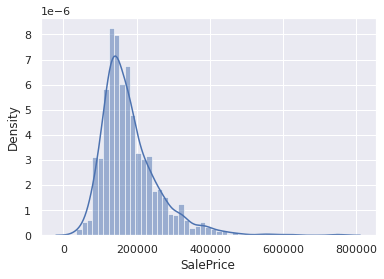

In [5]:
# visualizing the above distribution
sns.histplot(
    htrain['SalePrice'], kde=True,
    stat="density", kde_kws=dict(cut=3));

In [6]:
# We can look at its deviation from standard normal distribution.
# skewness (lack of symmetry) and excess kurtosis (heavy/light tailed)
print("Skewness: %f" % htrain['SalePrice'].skew())
print("Kurtosis: %f" % htrain['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


Positive values for the skewness indicate data that are skewed right. That is, the right tail is longer than the left tail. 

Positive values of excess kurtosis indicate that its tails are longer and fatter, and often its central peak is higher and sharper, as compared with standard normal.

In [7]:
htrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

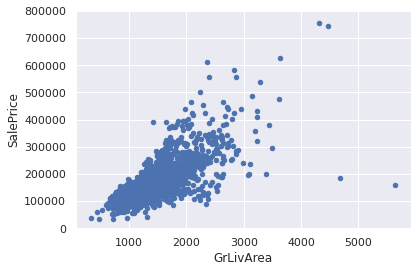

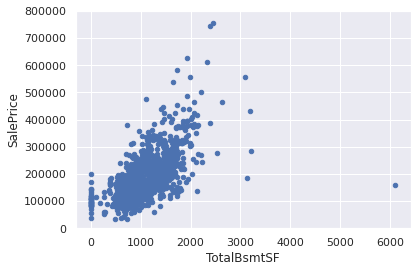

In [8]:
# Next we look at numerical variables GrLivArea and TotalBsmtSF
for var in ['GrLivArea', 'TotalBsmtSF']:
    data = pd.concat([htrain['SalePrice'], htrain[var]], axis=1)
    data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

`SalePrice` and `GrLivArea` seem to have linear relation.

`SalePrice` and `TotalBsmtSF` seem to have high solpe, if linear relation.

However, both relationships are positive, which means that as one variable increases, the other also increases. 

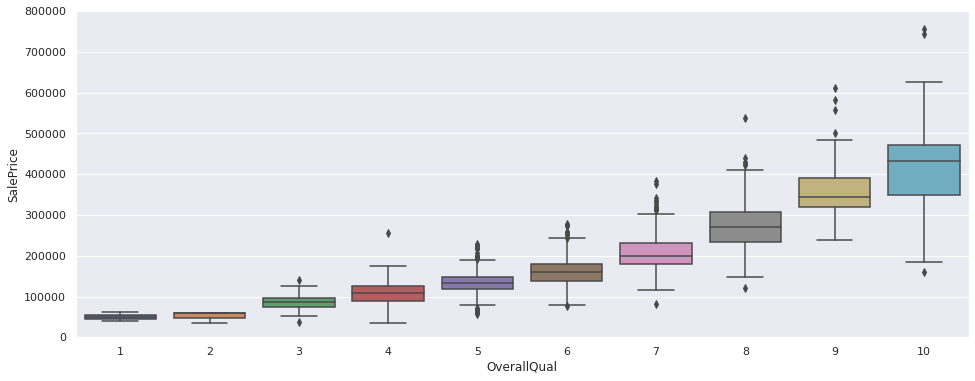

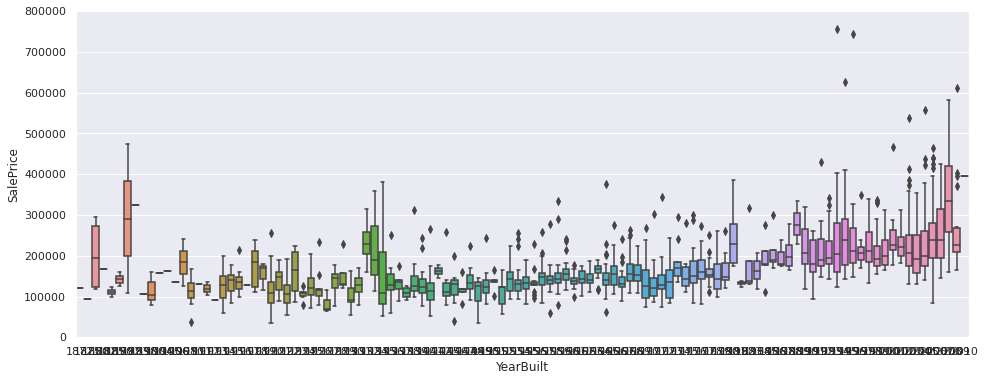

In [9]:
# Next we look at categorical variables OverallQual and YearBuilt
for var in ['OverallQual', 'YearBuilt']:
    data = pd.concat([htrain['SalePrice'], htrain[var]], axis=1)
    f, ax = plt.subplots(figsize=(16, 6))
    fig = sns.boxplot(x=var, y="SalePrice", data=data)
    fig.axis(ymin=0, ymax=800000);

It appears that `SalePrice` is in constant prices. That is, the effect of inflation is removed so than prices are comparable over the years.

The relationship seems to be stronger in the case of `OverallQual`, where the box plot shows how sales prices increase with the overall quality.

We just analysed four variables, but there are many other that we should analyse. We will use correlation matrix to choose the right features.

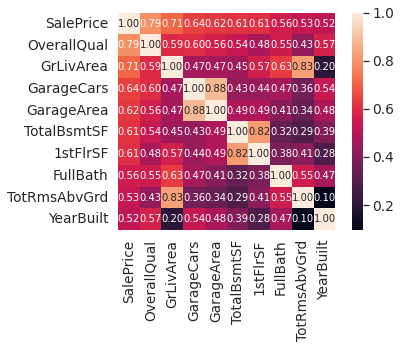

In [10]:
# variables correlated with SalePrice
k = 10 #number of variables for heatmap
corrmat = htrain.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(htrain[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Therefore, we will work with the following set of variables:
1. `OverallQual`
2. `GrLivArea` (equivalent to `TotRmsAbvGrd`)
3. `GarageCars` (equivalent to `GarageArea`)
4. `TotalBsmtSF` (equivalent to `1stFlrSF`)
5. `FullBath`
6. `YearBuilt`

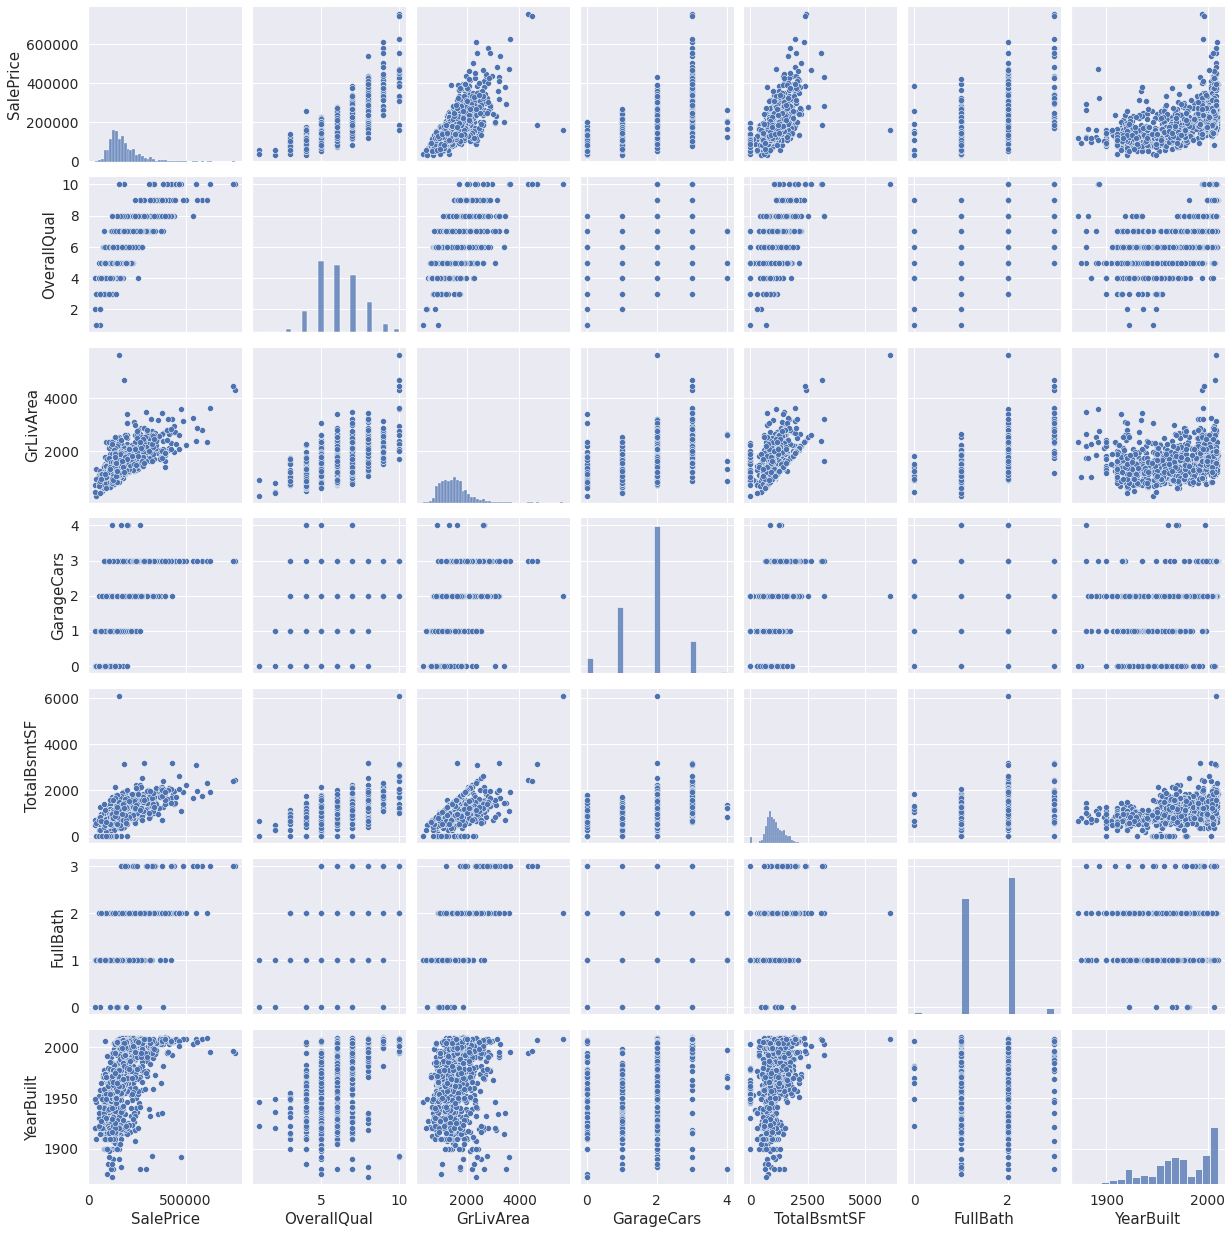

In [11]:
# scatterplot between SalePrice and correlated variables
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 
        'FullBath', 'YearBuilt']
sns.pairplot(htrain[cols], height = 2.5)
plt.show();

The plot between `GrLivArea` and `TotalBsmtSF` has a line acting like a border, signifying that basement area is lesser than the above ground living area.

On the other hand, the plot between `YearBuilt` and `SalePrice` shows that price increase faster with latest year.

In [12]:
#version of the data set with missing values removed
htrain.dropna()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


Bad idea.

In [13]:
#missing data
total = htrain.isnull().sum().sort_values(ascending=False)
percent = ((htrain.isnull().sum()/htrain.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


We have missing values for `LotFrontage`, `Alley`, `MasVnrType`, `MasVnrArea`, `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, `Electrical`, `FireplaceQu`, `GarageType`, `GarageYrBlt`, `GarageFinish`, `GarageQual`, `GarageCond`, `PoolQC`, `Fence`, and `MiscFeature`.

We can drop the variables `PoolQC`, `MiscFeature`, `Alley`, `Fence`, `FireplaceQu` and `LotFrontage` since a big chunk majorit of data about them is missing.

Let's also look at the coorelation matrix.

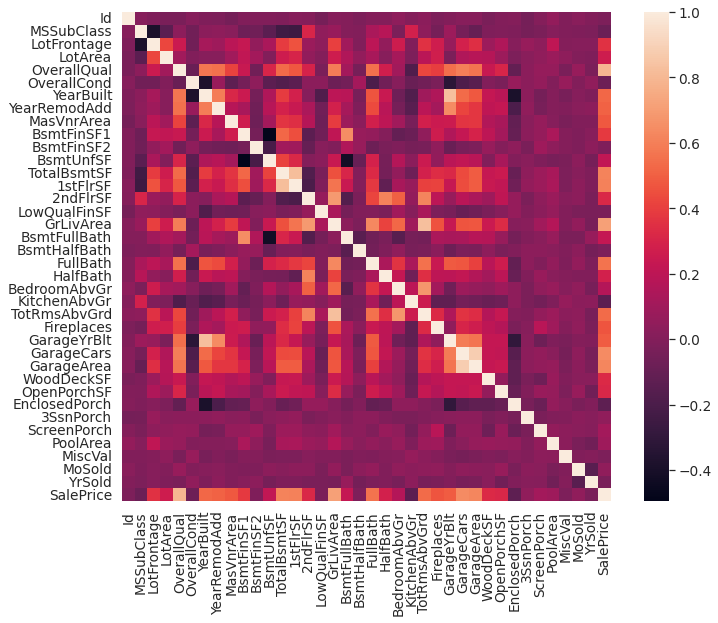

In [14]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(htrain.corr(), xticklabels=True, yticklabels=True, square=True);

We observe that there is strong correlation between
1. `GarageYrBlt` and `GarageCars`
2. `MasVnrArea` and `OverallQual`

Therefore, we can safely drop the varibles `GarageYrBlt` (and related categorical variables`GarageCond`, `GarageType`, `GarageFinish`, and `GarageQual`), `MasVnrArea` (and related categorical variable `MasVnrType`), and since we are keeping `GarageCars` and `OverallQual`, respectively.

Moreover, since `BsmtExposure`, `BsmtFinType2`, `BsmtFinType1`, `BsmtCond`, `BsmtQual` are categorical variables corresponding to the ones already taken into account. Therefore, it will be better to drop these varaibles instead of the entries with missing data.

We will drop the observation corresponding to `Electrical` missing data.

In [15]:
htrain = htrain.drop((missing_data[missing_data['Total'] > 1]).index, axis=1)
htrain = htrain.drop(htrain.loc[htrain['Electrical'].isnull()].index)

In [16]:
htrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 63 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             1459 non-null   int64 
 1   MSSubClass     1459 non-null   int64 
 2   MSZoning       1459 non-null   object
 3   LotArea        1459 non-null   int64 
 4   Street         1459 non-null   object
 5   LotShape       1459 non-null   object
 6   LandContour    1459 non-null   object
 7   Utilities      1459 non-null   object
 8   LotConfig      1459 non-null   object
 9   LandSlope      1459 non-null   object
 10  Neighborhood   1459 non-null   object
 11  Condition1     1459 non-null   object
 12  Condition2     1459 non-null   object
 13  BldgType       1459 non-null   object
 14  HouseStyle     1459 non-null   object
 15  OverallQual    1459 non-null   int64 
 16  OverallCond    1459 non-null   int64 
 17  YearBuilt      1459 non-null   int64 
 18  YearRemodAdd   1459 non-null

# Basic data manipulation & preliminary feature engineering